In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
sys.path.append('../')

from punkt import (compute_hsm,
                   compute_hsm_tensor,
                   compute_vsm,
                   cic_deposition, 
                   isotropic_kernel_deposition, 
                   anisotropic_kernel_deposition)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
ds = pn.load('/shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_554.hdf5')


boxsize  = 15000
NN       = 16
periodic = True
gridnum  = 512
extent   = np.array([0, boxsize])

pos      = ds.gas['pos']
masses   = ds.gas['mass']
vel      = ds.gas['vel']
vx       = ds.gas['vel'][:, 0]
vy       = ds.gas['vel'][:, 1]
vz       = ds.gas['vel'][:, 2]
temp     = ds.gas['temp']
metals   = ds.gas['metals'][:, 0]


# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm, _, nn_inds, _ = compute_hsm(pos, NN, boxsize)
hmat, eλ, ev       = compute_hsm_tensor(pos, masses, NN, boxsize)
vsm                = compute_vsm(vel, nn_inds)

# stack all quantities to deposit
quantities = np.stack([masses, 
                       vx, vy, vz, 
                       vsm[:, 0], vsm[:, 1], vsm[:, 2]], axis=-1)
print(quantities.shape)

# dow we need to average the deposited quantities or not?
averaged   = [False, 
              True, True, True,
              True, True, True]

/home/maurbe/data/conda/envs/xenv/lib/python3.11/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/xenv/lib/python3.11/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


(1949593, 7)


In [3]:
mask = np.logical_and(pos[:, -1] > 14000,
                      pos[:, -1] < 15000)

pos    = pos[mask]
masses = masses[mask]
hsm    = hsm[mask]
hmat   = hmat[mask]
quantities = quantities[mask]

pos = pos[:, :2]

kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [4]:

fields_cic, _ = cic_deposition(**kwargs)

fields_ada, _ = cic_deposition(**kwargs, num_nn=NN)

fields_iso, _ = isotropic_kernel_deposition(**kwargs, hsm=hsm)

fields_ani, _, eλ_2d, ev_2d = anisotropic_kernel_deposition(**kwargs, hmat=hmat, plane='xy', return_evals=True)

100%|██████████| 153687/153687 [03:46<00:00, 679.83it/s] 


In [5]:
fields = [fields_cic,
          fields_ada, 
          fields_iso,
          fields_ani]

/sctmp/maurbe/ipykernel_2995477/379174130.py:6: RuntimeWarning: divide by zero encountered in log10
  ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)


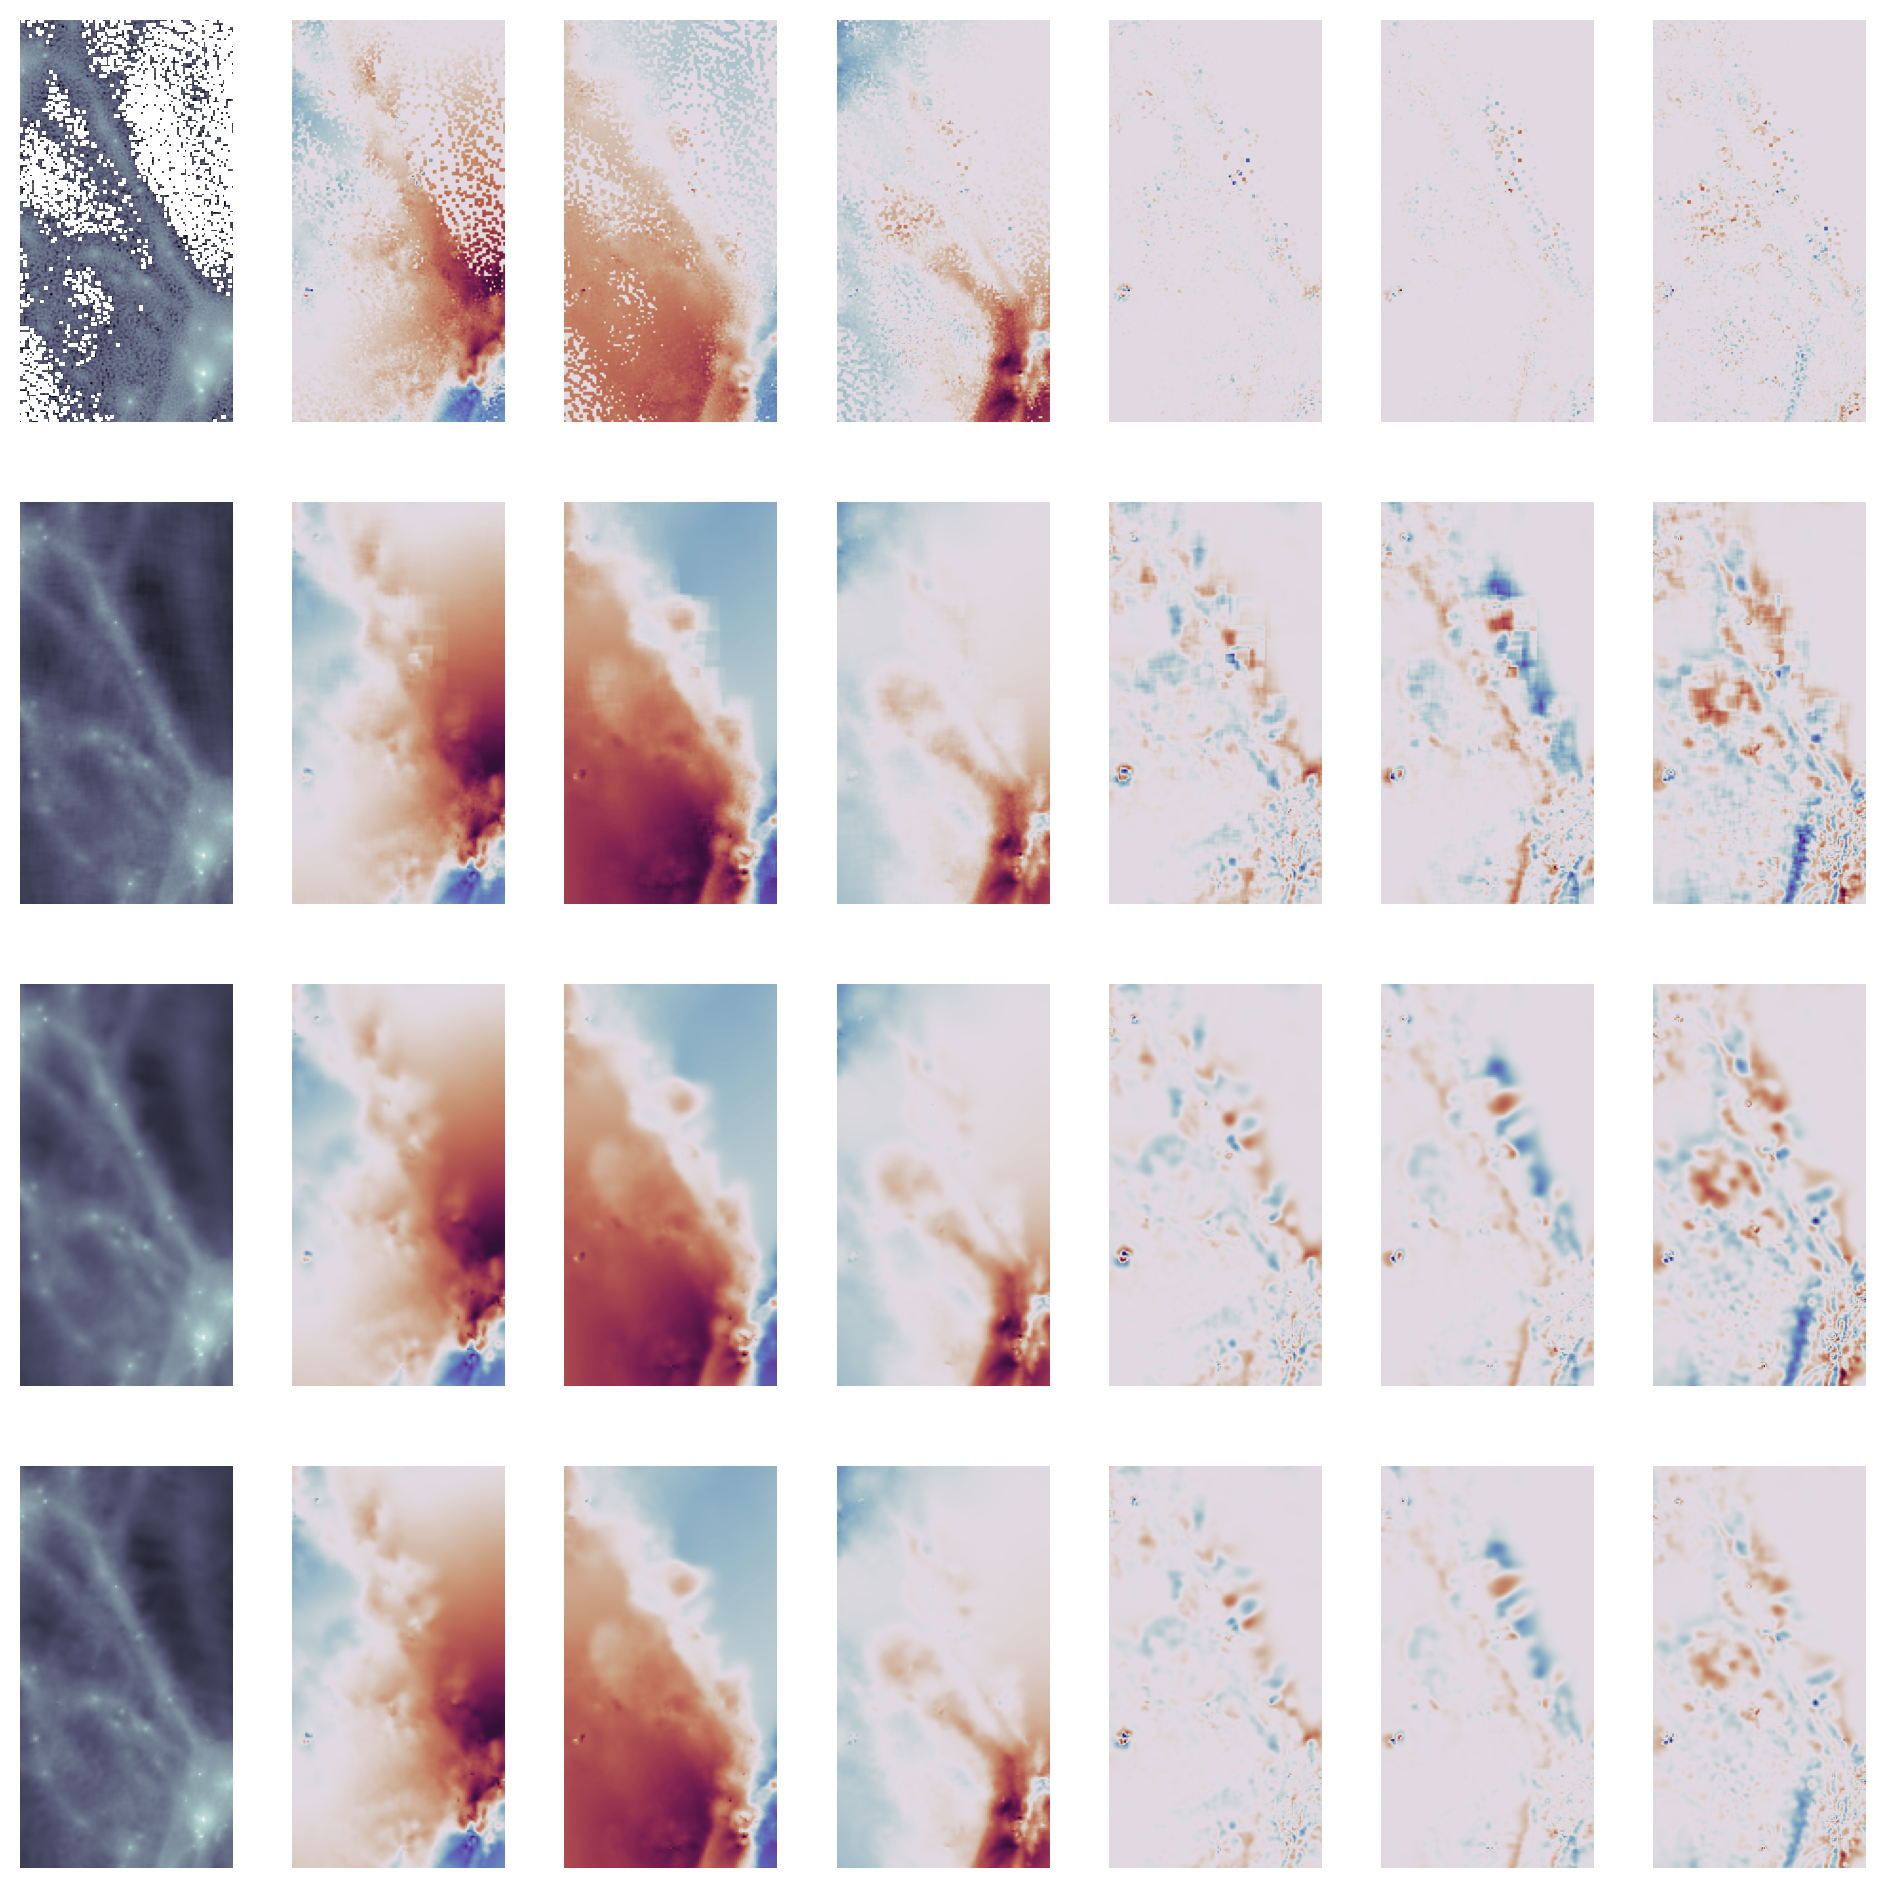

In [8]:
fig, ax = plt.subplots(4, 7, figsize=(12, 12))

for j in range(4):
    fov = np.s_[300:, 400:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
    
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 2].imshow(fields[j][fov][...,2], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 3].imshow(fields[j][fov][...,3], cmap='twilight_shifted', norm=colors.CenteredNorm())
    
    ax[j, 4].imshow(fields[j][fov][...,-3], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 5].imshow(fields[j][fov][...,-2], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 6].imshow(fields[j][fov][...,-1], cmap='twilight_shifted', norm=colors.CenteredNorm())

for a in ax.flat:
    a.axis('off')
    
fig.savefig('plots/deposition_comparison_σv.png', transparent=True, dpi=300)
plt.show()